In [6]:
%matplotlib inline

from collections import OrderedDict
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from PIL import Image
from skimage import transform, color
import numpy as np
import scipy.fftpack
from scipy.signal import spectrogram
import h5py
import matplotlib.pyplot as plt

# original_train_file = 'data/scsn_p_2000_2017_6sec_0.5r_pick_train.hdf5'
train_filepath = 'data/scsn_p_2000_2017_6sec_0.5r_pick_train_mix.hdf5'
test_filepath = 'data/scsn_p_2000_2017_6sec_0.5r_pick_test_mix.hdf5'
dataset_size = 100
features_key = 'X'
labels_key = 'pwave'

# Train on GPU, if available.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# Set up Dataset, Spectrogram transform
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class WaveformDataset(Dataset):
  """Has p-wave and noise waveforms."""

  def __init__(self, filepath, dataset_size=-1, transform=None):
    """
    Args:
      filepath (string): Path to .h5py file.
      transform (callable, optional): Applied on the dataset.
    """
    waveforms_key = 'X'
    labels_key = 'pwave' 

    # Open, read, and close the file.
    file = h5py.File(filepath, 'r')
    dataset_size = dataset_size if dataset_size > 0 \
                   else len(file[waveforms_key])
    self.samples = {
      "waveforms": file[waveforms_key][:dataset_size],
      "labels": file[labels_key][:dataset_size]
    }
    file.close()

    # Note: transform is the argument passed to __init__, NOT skimage.transform
    self.transform = transform

  def __len__(self):
    return len(self.samples["waveforms"])

  def __getitem__(self, idx):
    waveform = self.samples["waveforms"][idx]
    if self.transform:
      waveform = self.transform(waveform)
    
    return {
      "waveform": waveform,
      "label": self.samples["labels"][idx]
    }

class Spectrogram(object):
  """Obtain the spectrogram of a given waveform."""

  def __call__(self, waveform):
    freqs, times, Sx = spectrogram(waveform, fs=100, window='hamming',
                                   nperseg=30, noverlap=0,
                                   detrend='linear', scaling='spectrum')
    
    # Convert range while maintaining ratio
    min1 = np.amin(Sx)
    max1 = np.amax(Sx)
    min2 = 0
    max2 = 255
    Sx = ((Sx - min1) / (max1 - min1)) * (max2 - min2) + min2
    
    # PIL image
    return Image.fromarray(np.uint8(Sx))

In [8]:
# Load the data.
t = transforms.Compose([
  Spectrogram(),
  # transforms.ToPILImage(),
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=3),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406],
                       [0.229, 0.224, 0.225])
])

train_dataset = WaveformDataset(filepath=train_filepath,
                                dataset_size=dataset_size,
                                transform=t)
test_dataset = WaveformDataset(filepath=test_filepath,
                               dataset_size=dataset_size,
                               transform=t)

train_dataloader = DataLoader(train_dataset,
                              batch_size=2,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=16,
                             shuffle=True)

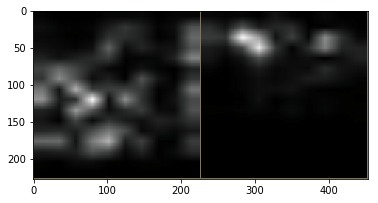

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
sample = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(sample["waveform"])

imshow(out)

In [13]:
# Model Architecture
model = torchvision.models.resnet18(pretrained=False)
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(in_features=512, out_features=2, bias=True)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.fc = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [11]:
epochs = 10
steps = 0
running_loss = 0
print_every = 1
for e in range(epochs):
    for sample in train_dataloader:
        steps += 1
        
        inputs = sample["waveform"].to(device)
        labels = sample["label"].to(device, dtype=torch.int64)
        
        optimizer.zero_grad()
        
        log_ps = model.forward(inputs)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for sample in test_dataloader:
                    inputs = sample["waveform"].to(device)
                    labels = sample["label"].to(device, dtype=torch.int64)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {e}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_dataloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_dataloader):.3f}")
            running_loss = 0
            model.train()


Epoch 0/10.. Train loss: 0.752.. Test loss: 4.727.. Test accuracy: 0.527
Epoch 0/10.. Train loss: 1.491.. Test loss: 0.681.. Test accuracy: 0.562
Epoch 0/10.. Train loss: 0.918.. Test loss: 2.235.. Test accuracy: 0.527
Epoch 0/10.. Train loss: 0.312.. Test loss: 14.854.. Test accuracy: 0.527
Epoch 0/10.. Train loss: 0.515.. Test loss: 84.128.. Test accuracy: 0.500
Epoch 0/10.. Train loss: 2.510.. Test loss: 214.442.. Test accuracy: 0.500
Epoch 0/10.. Train loss: 2.052.. Test loss: 285.094.. Test accuracy: 0.527
Epoch 0/10.. Train loss: 1.919.. Test loss: 274.063.. Test accuracy: 0.500
Epoch 0/10.. Train loss: 0.938.. Test loss: 184.757.. Test accuracy: 0.500


KeyboardInterrupt: 

## Appendix

### Preparing the Data

One of the challenges of modifying the architecture of an existing CNN is to accomodate for the first layer's input tensor shape.

For this problem specifically, **how do we translate time-series data of shape (300,) into a (224, 224, 3) tensor?**

Briefly, what I did was obtain a spectrogram of the waveform by applying DFT to overlapping windows of the data. This gives us a heatmap of which frequencies had a stronger presence at some specific time. Then, I treat the spectrogram as an image and upscale it to the required dimensions, (224, 224). Finally, I treat the upscaled spectrogram as a greyscale image to give it the 3 channels necessary to work with Resnet.

Below is an elaboration of the process outlined above, with a noise waveform and p-wave waveform used as an example.

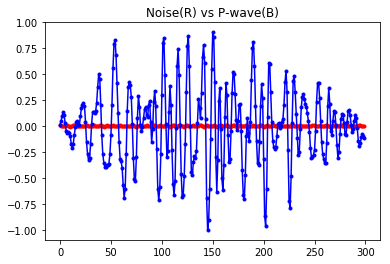

In [14]:
"""
First, let's load the data and compare the two types of waveforms.
"""
file = h5py.File(train_filepath, 'r')
dataset = file.get(features_key)[:dataset_size]
file.close()

noise = dataset[0]
pwave = dataset[1]

plt.title('Noise(R) vs P-wave(B)')
plt.plot(range(len(noise)), noise, 'r.-')
plt.plot(range(len(pwave)), pwave, 'b.-')
plt.show()

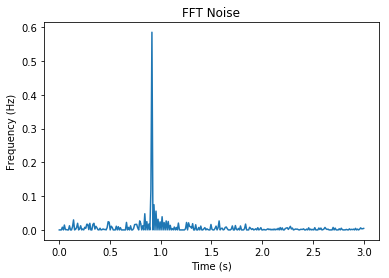

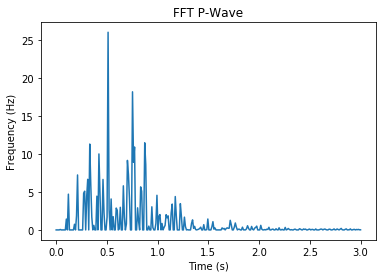

In [15]:
"""
Then, let's take a look at the Fast Fourier Transform (just the real part) of the waveforms.
We actually don't need this to calculate the spectrograms, but it's here to get a better
understanding of how the waveforms can be interpreted.
"""
noise_fft = list(map(lambda x: 0 if x < 0 else x, scipy.fftpack.rfft(noise)))
pwave_fft = list(map(lambda x: 0 if x < 0 else x, scipy.fftpack.rfft(pwave)))
t = np.linspace(0, 3, 300)

plt.title("FFT Noise")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.plot(t, noise_fft)
plt.show()

plt.title("FFT P-Wave")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.plot(t, pwave_fft)
plt.show()

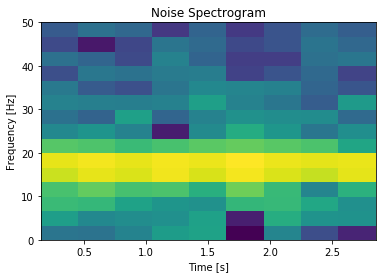

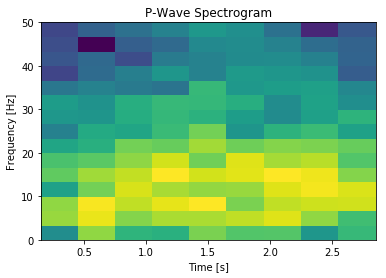

In [16]:
"""
Next, let's get the spectrograms using scipy.signal.spectrogram
"""
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
from scipy.signal import spectrogram

noise_freqs, noise_times, noise_Sx = spectrogram(noise, fs=100, window='hamming',
                                                nperseg=30, noverlap=0,
                                                detrend='linear', scaling='spectrum')
pwave_freqs, pwave_times, pwave_Sx = spectrogram(pwave, fs=100, window='hamming',
                                                nperseg=30, noverlap=0,
                                                detrend='linear', scaling='spectrum')

plt.pcolormesh(noise_times, noise_freqs, 10 * np.log10(noise_Sx), cmap='viridis')
plt.title('Noise Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]');
plt.show()

plt.title('P-Wave Spectrogram')
plt.pcolormesh(pwave_times, pwave_freqs, 10 * np.log10(pwave_Sx), cmap='viridis')
plt.title('P-Wave Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.show()

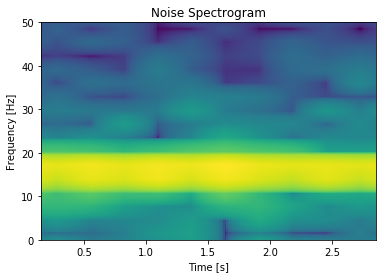

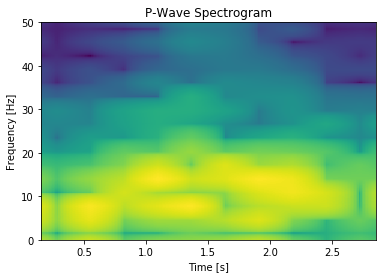

In [17]:
"""
We can already see how Resnet can accept these spectograms as images, but the
spectograms shape isn't quite right. Right now, it's (16, 10) and is determined
by the arguments passed to scipy.signal.spectrogram. Either way, we can resize
it to (224, 224) using torchvision.transforms.Grayscale (skimage.transform.resize works too).
"""
# https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=resize#skimage.transform.resize
from skimage.transform import resize

noise_Sx = resize(noise_Sx, (224, 224), mode='reflect')
pwave_Sx = resize(pwave_Sx, (224, 224), mode='reflect')

# In order to correctly print the spectrogram, we must also change the time and
# frequency lists to reflect the resized spectrograms.
noise_times = np.linspace(noise_times[0], noise_times[-1], 224)
noise_freqs = np.linspace(noise_freqs[0], noise_freqs[-1], 224)
pwave_times = np.linspace(pwave_times[0], pwave_times[-1], 224)
pwave_freqs = np.linspace(pwave_freqs[0], pwave_freqs[-1], 224)

plt.pcolormesh(noise_times, noise_freqs, 10 * np.log10(noise_Sx), cmap='viridis')
plt.title('Noise Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]');
plt.show()

plt.title('P-Wave Spectrogram')
plt.pcolormesh(pwave_times, pwave_freqs, 10 * np.log10(pwave_Sx), cmap='viridis')
plt.title('P-Wave Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.show()

In [18]:
"""
Getting closer now! The spectogram's shapes are (224, 224), but we're still missing
the three channels (RGB). So, let's treat the spectrograms like greyscale images to derive
the other channels. We can do this using skimage.color.gray2rgb (either spelling of gray works!).
"""
# http://scikit-image.org/docs/dev/user_guide/viewer.html
from skimage.color import gray2rgb
noise_Sx = gray2rgb(noise_Sx)
pwave_Sx = gray2rgb(pwave_Sx)
print(f"Noise Spectrogram Shape: {noise_Sx.shape}\nP-Wave Spectrogram Shape: {pwave_Sx.shape}")

Noise Spectrogram Shape: (224, 224, 3)
P-Wave Spectrogram Shape: (224, 224, 3)


## References